In [8]:
!pip install wikipedia-api spacy networkx matplotlib
!python -m spacy download en_core_web_sm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 41.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [9]:
!pip install wikipedia-api

# Import required modules
import wikipediaapi
import networkx as nx
import matplotlib.pyplot as plt

# Data from Wikidata for all those names.

In [10]:
import requests
import time
import csv
import wikipediaapi
import spacy
from requests.exceptions import HTTPError

# --- Configuration ---
HEADERS = {
    "User-Agent": "LatinAmericaScriptBot/1.0 (your.email@example.com)"
}
WIKIDATA_SEARCH_API = "https://www.wikidata.org/w/api.php"
SPARQL_ENDPOINT = "https://query.wikidata.org/sparql"
WIKI_API = wikipediaapi.Wikipedia(language='en', user_agent=HEADERS['User-Agent'])

# Load NLP model
nlp = spacy.load("en_core_web_sm")

# --- Intellectual Names ---
names = [
    "Cecilia Grierson", "Paulina Luisi", "Carmen Lyra", "Gabriela Mistral",
    "María Rosa Oliver", "Amalia de Castillo Ledón", "Blanca Luz Brum",
    "Nydia Lamarque", "Mirta Aguirre", "Victoria Ocampo", "Gilda de Mello e Souza",
    "Zélia Gattai", "Rubén Darío", "Joaquim Nabuco", "Bartolomeu Mitre",
    "Pedro Henriquez Ureña", "Alfonso Reyes", "José Carlos Mariátegui",
    "Manuel Gamio", "José María Arguedas", "José Luis Romero",
    "Ildefonso Pereda Valdéz", "Jorge Luis Borges", "José Ingenieros",
    "Domingo Faustino Sarmiento", "Beatriz Sarlo", "José Martí",
    "Fernando Ortiz", "Mariano Picón Salas", "Samuel Ramos"
]
name_set = set(names)

# --- Functions ---
def search_wikidata(name):
    """Search Wikidata for QID of a given person."""
    params = {
        "action": "wbsearchentities",
        "search": name,
        "language": "en",
        "format": "json",
        "limit": 1,
        "type": "item"
    }
    for attempt in range(5):
        try:
            response = requests.get(WIKIDATA_SEARCH_API, params=params, headers=HEADERS)
            response.raise_for_status()
            data = response.json()
            if data['search']:
                return data['search'][0]['id']
            else:
                print(f"❌ No Wikidata result for '{name}'")
                return None
        except HTTPError as e:
            if response.status_code == 429:
                wait_time = 2 ** attempt
                print(f"⚠️ Rate limit hit. Waiting {wait_time}s...")
                time.sleep(wait_time)
            else:
                print(f"❌ HTTP error for {name}: {e}")
                return None
    return None

def get_info_from_wikidata(qid):
    """Query Wikidata for bio properties."""
    query = f"""
    SELECT ?birthdate ?genderLabel ?nationalityLabel ?occupationLabel WHERE {{
      OPTIONAL {{ wd:{qid} wdt:P569 ?birthdate. }}
      OPTIONAL {{ wd:{qid} wdt:P21 ?gender. }}
      OPTIONAL {{ wd:{qid} wdt:P27 ?nationality. }}
      OPTIONAL {{ wd:{qid} wdt:P106 ?occupation. }}
      SERVICE wikibase:label {{ bd:serviceParam wikibase:language "en". }}
    }}
    """
    headers = {
        "Accept": "application/sparql-results+json",
        **HEADERS
    }
    for attempt in range(5):
        try:
            response = requests.get(SPARQL_ENDPOINT, params={"query": query}, headers=headers)
            response.raise_for_status()
            return response.json()
        except HTTPError as e:
            if response.status_code == 429:
                wait_time = 2 ** attempt
                print(f"⚠️ SPARQL rate limit hit for {qid}. Waiting {wait_time}s...")
                time.sleep(wait_time)
            else:
                print(f"❌ SPARQL error for {qid}: {e}")
                return None
    return None

def get_outgoing_links(name):
    """Get hyperlinks from Wikipedia page."""
    page = WIKI_API.page(name)
    if page.exists():
        return list(page.links.keys())
    else:
        print(f"❌ Wikipedia page not found for {name}")
        return []

def extract_mentioned_people(name):
    """Use NLP to extract PERSON entities from the Wikipedia page text."""
    page = WIKI_API.page(name)
    if not page.exists():
        return []
    text = page.text
    doc = nlp(text)
    people = set(ent.text.strip() for ent in doc.ents if ent.label_ == "PERSON")
    # Return only those we know in our set
    return list(people & name_set)

# --- Output CSV ---
output_file = "latin_american_intellectuals_with_mentions.csv"
fieldnames = ["Name", "Birthdate", "Gender", "Nationality", "Occupation", "WikipediaLinks", "MentionedPeople"]

results = []

# --- Main Loop ---
for name in names:
    print(f"🔍 Processing: {name}")
    qid = search_wikidata(name)
    birthdate = gender = nationality = occupation = ""
    wiki_links = []
    mentioned_people = []

    if qid:
        info = get_info_from_wikidata(qid)
        if info and info["results"]["bindings"]:
            row = info["results"]["bindings"][0]
            birthdate = row.get("birthdate", {}).get("value", "")
            gender = row.get("genderLabel", {}).get("value", "")
            nationality = row.get("nationalityLabel", {}).get("value", "")
            occupation = row.get("occupationLabel", {}).get("value", "")

    wiki_links = get_outgoing_links(name)
    mentioned_people = extract_mentioned_people(name)

    results.append({
        "Name": name,
        "Birthdate": birthdate,
        "Gender": gender,
        "Nationality": nationality,
        "Occupation": occupation,
        "WikipediaLinks": "; ".join(wiki_links),
        "MentionedPeople": "; ".join(mentioned_people)
    })

    time.sleep(2)

# --- Save Results ---
with open(output_file, mode="w", newline="", encoding="utf-8") as f:
    writer = csv.DictWriter(f, fieldnames=fieldnames)
    writer.writeheader()
    for row in results:
        writer.writerow(row)

print(f"\n✅ Data saved to {output_file}")


🔍 Processing: Cecilia Grierson
🔍 Processing: Paulina Luisi
🔍 Processing: Carmen Lyra
🔍 Processing: Gabriela Mistral
🔍 Processing: María Rosa Oliver
🔍 Processing: Amalia de Castillo Ledón
❌ No Wikidata result for 'Amalia de Castillo Ledón'
❌ Wikipedia page not found for Amalia de Castillo Ledón
🔍 Processing: Blanca Luz Brum
🔍 Processing: Nydia Lamarque
🔍 Processing: Mirta Aguirre
🔍 Processing: Victoria Ocampo
🔍 Processing: Gilda de Mello e Souza
❌ No Wikidata result for 'Gilda de Mello e Souza'
🔍 Processing: Zélia Gattai
🔍 Processing: Rubén Darío
🔍 Processing: Joaquim Nabuco
🔍 Processing: Bartolomeu Mitre
❌ Wikipedia page not found for Bartolomeu Mitre
🔍 Processing: Pedro Henriquez Ureña
🔍 Processing: Alfonso Reyes
🔍 Processing: José Carlos Mariátegui
🔍 Processing: Manuel Gamio
🔍 Processing: José María Arguedas
🔍 Processing: José Luis Romero
🔍 Processing: Ildefonso Pereda Valdéz
❌ No Wikidata result for 'Ildefonso Pereda Valdéz'
❌ Wikipedia page not found for Ildefonso Pereda Valdéz
🔍 P

In [11]:
import pandas as pd

# Load the CSV file
df = pd.read_csv('latin_american_intellectuals.csv')

# Print the dataframe as a table in console
print(df.to_markdown(index=False))


| Name                       | Birthdate            | Gender   | Nationality        | Occupation         |
|:---------------------------|:---------------------|:---------|:-------------------|:-------------------|
| Cecilia Grierson           | nan                  | nan      | nan                | nan                |
| Paulina Luisi              | 1875-09-22T00:00:00Z | female   | Uruguay            | teacher            |
| Carmen Lyra                | 1887-01-15T00:00:00Z | female   | Costa Rica         | writer             |
| Gabriela Mistral           | 1889-04-07T00:00:00Z | female   | Chile              | writer             |
| María Rosa Oliver          | 1898-09-10T00:00:00Z | female   | Argentina          | writer             |
| Blanca Luz Brum            | 1905-05-31T00:00:00Z | female   | Uruguay            | painter            |
| Nydia Lamarque             | 1906-01-01T00:00:00Z | female   | Argentina          | writer             |
| Mirta Aguirre              | 1912-1

In [ ]:
import requests
import time
import csv
import wikipediaapi
from requests.exceptions import HTTPError

# Seed names
names = [
    "Cecilia Grierson", "Paulina Luisi", "Carmen Lyra", "Gabriela Mistral",
    "María Rosa Oliver", "Amalia de Castillo Ledón", "Blanca Luz Brum",
    "Nydia Lamarque", "Mirta Aguirre", "Victoria Ocampo", "Gilda de Mello e Souza",
    "Zélia Gattai", "Rubén Darío", "Joaquim Nabuco", "Bartolomeu Mitre",
    "Pedro Henriquez Ureña", "Alfonso Reyes", "José Carlos Mariátegui",
    "Manuel Gamio", "José María Arguedas", "José Luis Romero",
    "Ildefonso Pereda Valdéz", "Jorge Luis Borges", "José Ingenieros",
    "Domingo Faustino Sarmiento", "Beatriz Sarlo", "José Martí",
    "Fernando Ortiz", "Mariano Picón Salas", "Samuel Ramos"
]

HEADERS = {
    "User-Agent": "LatinAmericaScriptBot/1.1 (touseeqkhanswl@gmail.com)"
}
WIKIDATA_SEARCH_API = "https://www.wikidata.org/w/api.php"
SPARQL_ENDPOINT = "https://query.wikidata.org/sparql"
WIKI = wikipediaapi.Wikipedia(language='en', user_agent='LatinAmericaScriptBot/1.1 (touseeqkhanswl@gmail.com)')

def search_wikidata(name):
    params = {
        "action": "wbsearchentities",
        "search": name,
        "language": "en",
        "format": "json",
        "limit": 1,
        "type": "item"
    }
    for attempt in range(5):
        try:
            response = requests.get(WIKIDATA_SEARCH_API, params=params, headers=HEADERS)
            response.raise_for_status()
            data = response.json()
            if data['search']:
                return data['search'][0]['id']
            else:
                print(f"❌ No QID found for '{name}'")
                return None
        except HTTPError as e:
            if response.status_code == 429:
                wait_time = (2 ** attempt)
                print(f"Rate limit hit. Waiting {wait_time}s...")
                time.sleep(wait_time)
            else:
                print(f"⚠️ Error fetching QID for '{name}': {e}")
                return None
    return None

def get_info_from_wikidata(qid):
    query = f"""
    SELECT ?birthdate ?genderLabel ?nationalityLabel ?occupationLabel WHERE {{
      OPTIONAL {{ wd:{qid} wdt:P569 ?birthdate. }}
      OPTIONAL {{ wd:{qid} wdt:P21 ?gender. }}
      OPTIONAL {{ wd:{qid} wdt:P27 ?nationality. }}
      OPTIONAL {{ wd:{qid} wdt:P106 ?occupation. }}
      SERVICE wikibase:label {{ bd:serviceParam wikibase:language "en". }}
    }}
    """
    headers = {
        "Accept": "application/sparql-results+json",
        **HEADERS
    }
    for attempt in range(5):
        try:
            response = requests.get(SPARQL_ENDPOINT, params={"query": query}, headers=headers)
            response.raise_for_status()
            return response.json()
        except HTTPError as e:
            if response.status_code == 429:
                wait_time = (2 ** attempt)
                print(f"SPARQL 429 for QID {qid}, waiting {wait_time}s...")
                time.sleep(wait_time)
            else:
                print(f"⚠️ SPARQL error for {qid}: {e}")
                return None
    return None

def get_wikipedia_link_counts(name, all_names_set):
    page = WIKI.page(name)
    if not page.exists():
        return 0, 0

    outgoing_links = list(page.links.keys())
    outgoing_count = len(outgoing_links)

    incoming_count = 0
    for other in all_names_set:
        if other == name:
            continue
        other_page = WIKI.page(other)
        if other_page.exists() and name in other_page.links: # Check if other_page exists before checking links
            incoming_count += 1
        time.sleep(0.5)  # slow down

    return outgoing_count, incoming_count

# Output CSV
output_file = "latin_american_intellectuals.csv"
results = []

all_names_set = set(names)

for name in names:
    print(f"\n🔎 Processing: {name}")
    qid = search_wikidata(name)
    birthdate = gender = nationality = occupation = ""

    if qid:
        data = get_info_from_wikidata(qid)
        if data:
            bindings = data['results']['bindings']
            if bindings:
                row = bindings[0]
                birthdate = row.get("birthdate", {}).get("value", "")
                gender = row.get("genderLabel", {}).get("value", "")
                nationality = row.get("nationalityLabel", {}).get("value", "")
                occupation = row.get("occupationLabel", {}).get("value", "")

    # Fetch Wikipedia outgoing/incoming link counts
    out_count, in_count = get_wikipedia_link_counts(name, all_names_set)

    results.append({
        "Name": name,
        "QID": qid or "",
        "InCSV": "Yes",
        "Birthdate": birthdate,
        "Gender": gender,
        "Nationality": nationality,
        "Occupation": occupation,
        "OutgoingLinks": out_count,
        "IncomingLinks": in_count
    })

    time.sleep(2)  # avoid rate limiting

# Save CSV
with open(output_file, mode='w', newline='', encoding='utf-8') as f:
    fieldnames = ["Name", "QID", "InCSV", "Birthdate", "Gender", "Nationality", "Occupation", "OutgoingLinks", "IncomingLinks"]
    writer = csv.DictWriter(f, fieldnames=fieldnames)
    writer.writeheader()
    for row in results:
        writer.writerow(row)

print(f"\n✅ Final dataset saved to: {output_file}")


🔎 Processing: Cecilia Grierson

🔎 Processing: Paulina Luisi

🔎 Processing: Carmen Lyra

🔎 Processing: Gabriela Mistral

🔎 Processing: María Rosa Oliver

🔎 Processing: Amalia de Castillo Ledón
❌ No QID found for 'Amalia de Castillo Ledón'

🔎 Processing: Blanca Luz Brum

🔎 Processing: Nydia Lamarque

🔎 Processing: Mirta Aguirre

🔎 Processing: Victoria Ocampo

🔎 Processing: Gilda de Mello e Souza
❌ No QID found for 'Gilda de Mello e Souza'

🔎 Processing: Zélia Gattai

🔎 Processing: Rubén Darío

🔎 Processing: Joaquim Nabuco

🔎 Processing: Bartolomeu Mitre

🔎 Processing: Pedro Henriquez Ureña

🔎 Processing: Alfonso Reyes

🔎 Processing: José Carlos Mariátegui

🔎 Processing: Manuel Gamio

🔎 Processing: José María Arguedas

🔎 Processing: José Luis Romero

🔎 Processing: Ildefonso Pereda Valdéz
❌ No QID found for 'Ildefonso Pereda Valdéz'

🔎 Processing: Jorge Luis Borges

🔎 Processing: José Ingenieros

🔎 Processing: Domingo Faustino Sarmiento

🔎 Processing: Beatriz Sarlo

🔎 Processing: José Mar

In [12]:
import wikipediaapi

wiki = wikipediaapi.Wikipedia(
    language='en',
    user_agent='GabrielaMistralNetwork/1.0 (touseeqkhanswl@gmail.com)'
)

In [13]:
# Define the person
person = "Gabriela Mistral"

# Fetch the page
page = wiki.page(person)

# Display page summary
print("🔹 Summary (first 500 characters):")
print(page.summary[:500])


🔹 Summary (first 500 characters):
Lucila Godoy Alcayaga (Latin American Spanish: [luˈsila ɣoˈðoj alkaˈʝaɣa]; 7 April 1889 – 10 January 1957), known by her pseudonym Gabriela Mistral (Spanish: [ɡaˈβɾjela misˈtɾal]), was a Chilean poet-diplomat, journalist and educator. She read widely in theosophy, became a member of the Secular Franciscan Order or  Third Franciscan order in 1925, but rarely attended mass. She was the first Latin American author to receive a Nobel Prize in Literature in 1945, "for her lyric poetry which, inspired


In [14]:
# Fetch links from the page
links = list(page.links.keys())
print(f"\n🔹 Total outgoing links found on '{person}': {len(links)}")
print("\n🔹 Sample links:")
print(links[:10])  # show first 10



🔹 Total outgoing links found on 'Gabriela Mistral': 425

🔹 Sample links:
['1901 Nobel Prize in Literature', '1902 Nobel Prize in Literature', '1903 Nobel Prize in Literature', '1904 Nobel Prize in Literature', '1905 Nobel Prize in Literature', '1906 Nobel Prize in Literature', '1907 Nobel Prize in Literature', '1908 Nobel Prize in Literature', '1909 Nobel Prize in Literature', '1910 Nobel Prize in Literature']


In [15]:
import requests

def get_incoming_links(title, limit=50):
    url = "https://en.wikipedia.org/w/api.php"
    params = {
        "action": "query",
        "format": "json",
        "list": "backlinks",
        "bltitle": title,
        "bllimit": limit,
        "blnamespace": 0  # Only articles, not Talk/User/etc
    }

    response = requests.get(url, params=params)
    data = response.json()

    backlinks = [entry["title"] for entry in data["query"]["backlinks"]]
    return backlinks

# Get incoming links
incoming_links = get_incoming_links(person)
print(f"\n🔹 Incoming links to '{person}': {len(incoming_links)}")
print("Sample incoming links:", incoming_links[:10])



🔹 Incoming links to 'Gabriela Mistral': 50
Sample incoming links: ['Albert Camus', 'Anatole France', 'André Gide', 'Aleksandr Solzhenitsyn', 'Alexander Fleming', 'April 7', 'Bertrand Russell', 'Boris Pasternak', 'Chile', 'Czesław Miłosz']


In [16]:
print("\n========== SUMMARY ==========")
print(f"🔗 '{person}' outgoing links to {len(links)} pages.")
print(f"🔁 '{person}' incoming links / is linked from {len(incoming_links)} pages.")


========== SUMMARY ==========
🔗 'Gabriela Mistral' outgoing links to 425 pages.
🔁 'Gabriela Mistral' incoming links / is linked from 50 pages.


In [17]:
import wikipediaapi # Use wikipedia-api
import requests
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# Set language and user agent
wiki = wikipediaapi.Wikipedia(language="en", user_agent="MyWikipediaApp/1.0 (my.email@example.com)")
person = "Gabriela Mistral"

# ---- Fetch Outgoing Links ----
page = wiki.page(person) # Use wikipedia-api
outgoing_links = list(page.links.keys()) # Use wikipedia-api

# ---- Fetch Incoming Links (Backlinks) ----
def get_incoming_links(title, limit=100):
    url = "https://en.wikipedia.org/w/api.php"
    params = {
        "action": "query",
        "format": "json",
        "list": "backlinks",
        "bltitle": title,
        "bllimit": limit,
        "blnamespace": 0
    }
    response = requests.get(url, params=params)
    data = response.json()
    return [entry["title"] for entry in data["query"]["backlinks"]]

incoming_links = get_incoming_links(person)

# ---- Save to CSV ----
df = pd.DataFrame({
    "Type": ["Outgoing"] * len(outgoing_links) + ["Incoming"] * len(incoming_links),
    "Link_Title": outgoing_links + incoming_links
})
df.to_csv(f"{person.replace(' ', '_')}_wiki_links.csv", index=False)
print(f"🔹 Data saved to '{person.replace(' ', '_')}_wiki_links.csv'")

🔹 Data saved to 'Gabriela_Mistral_wiki_links.csv'


✅ Total nodes: 426
✅ Total edges: 445
🔄 Simulated incoming links found from: 20 pages


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128260 (\N{ANTICLOCKWISE DOWNWARDS AND UPWARDS OPEN CIRCLE ARROWS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128260 (\N{ANTICLOCKWISE DOWNWARDS AND UPWARDS OPEN CIRCLE ARROWS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


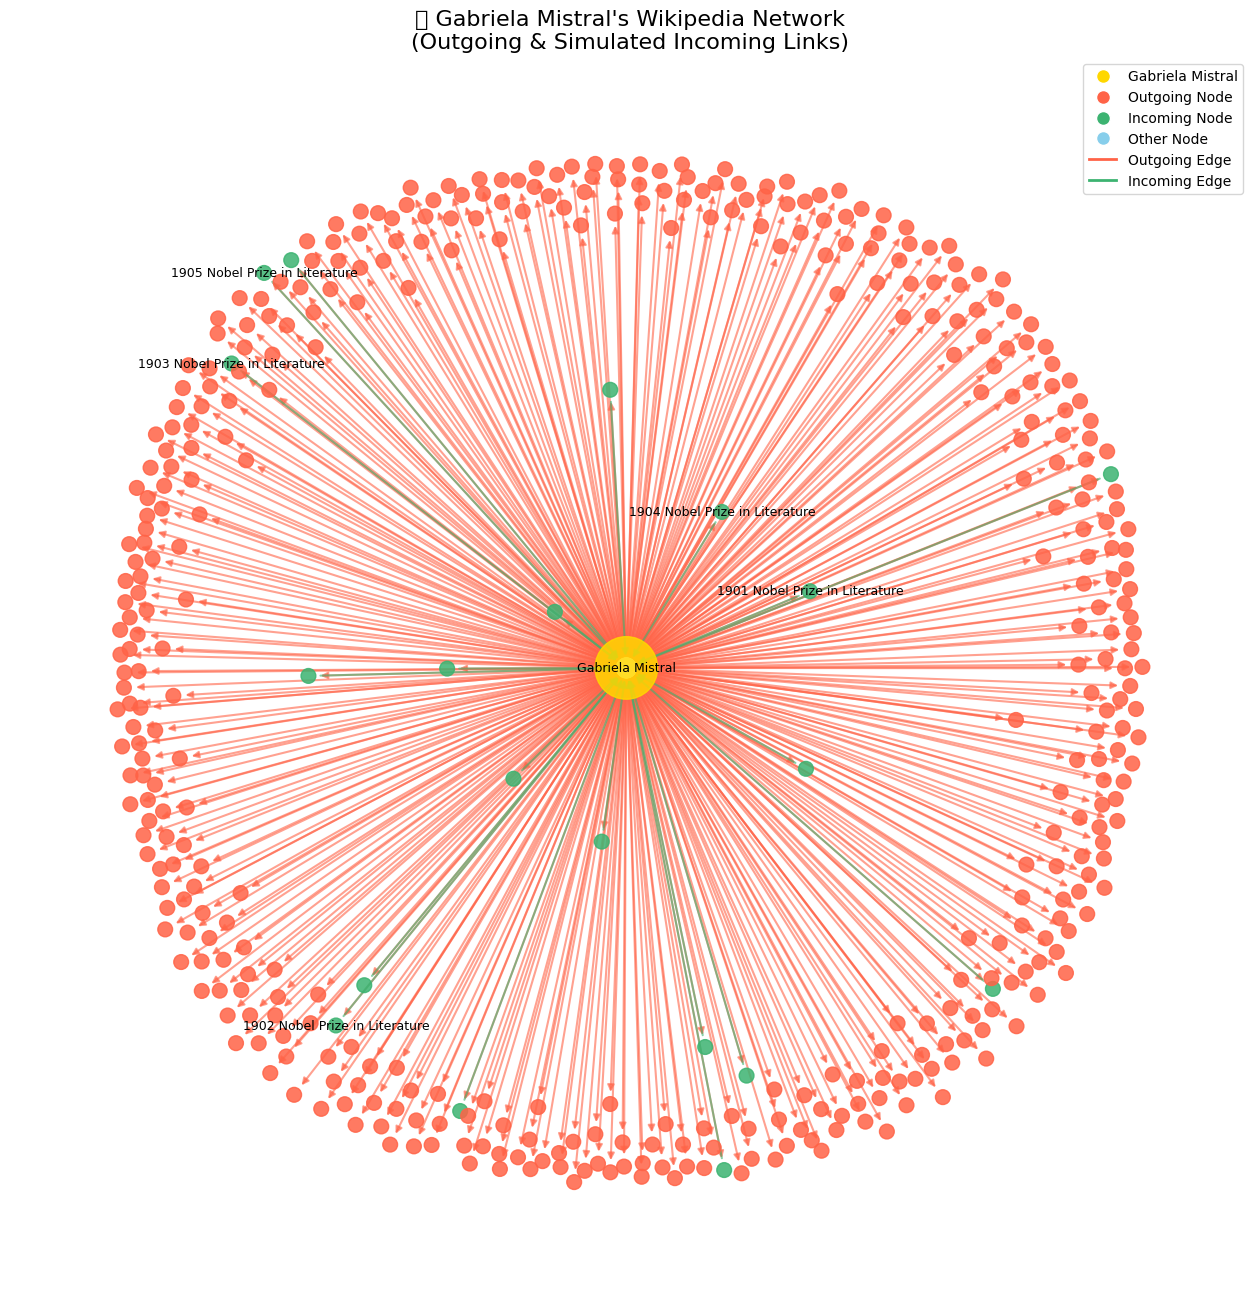

In [18]:
import wikipediaapi
import matplotlib.pyplot as plt
import networkx as nx
from matplotlib.lines import Line2D

# Define the person
person = "Gabriela Mistral"

# Create the directed graph
G = nx.DiGraph()
G.add_node(person)

# Initialize Wikipedia API
wiki = wikipediaapi.Wikipedia(language="en", user_agent="GabrielaMistralNetwork/1.0 (touseeqkhanswl@gmail.com)")

# Fetch outgoing links from the person page
try:
    page = wiki.page(person)
    links = list(page.links.keys())
except Exception as e:
    print(f"Error fetching page: {e}")
    links = []

# Add outgoing links
for link in links:
    G.add_node(link)
    G.add_edge(person, link)

# Simulate incoming links (check if some of those link back to the person)
incoming_sources = []
for link in links[:20]:  # Limit for speed
    try:
        sub_page = wiki.page(link)
        if person in sub_page.links.keys():
            G.add_node(link)
            G.add_edge(link, person)  # Incoming link
            incoming_sources.append(link)
    except Exception:
        continue

print(f"✅ Total nodes: {G.number_of_nodes()}")
print(f"✅ Total edges: {G.number_of_edges()}")
print(f"🔄 Simulated incoming links found from: {len(incoming_sources)} pages")

# Compute PageRank
pagerank_scores = nx.pagerank(G)

# Color map for nodes
color_map = []
for node in G.nodes():
    if node == person:
        color_map.append("gold")
    elif node in incoming_sources:
        color_map.append("mediumseagreen")  # Incoming
    elif node in links:
        color_map.append("tomato")  # Outgoing
    else:
        color_map.append("skyblue")  # Other

# Node size by PageRank
node_sizes = [pagerank_scores.get(node, 0) * 50000 for node in G.nodes()]

# Layout
pos = nx.spring_layout(G, k=0.45, seed=42)

# Edges
out_edges = [(person, link) for link in links if G.has_edge(person, link)]
in_edges = [(link, person) for link in incoming_sources if G.has_edge(link, person)]
remaining_edges = list(set(G.edges()) - set(out_edges) - set(in_edges))

# Draw nodes
plt.figure(figsize=(16, 16))
nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=color_map, alpha=0.85)

# Draw edges
nx.draw_networkx_edges(G, pos, edgelist=out_edges, edge_color='tomato', arrows=True, arrowstyle='-|>', width=1.5, alpha=0.6)
nx.draw_networkx_edges(G, pos, edgelist=in_edges, edge_color='mediumseagreen', arrows=True, arrowstyle='-|>', width=1.5, alpha=0.6)
nx.draw_networkx_edges(G, pos, edgelist=remaining_edges, edge_color='gray', alpha=0.2)

# Draw selected labels
labels = {person: person}
for node in incoming_sources[:5] + links[:5]:  # Limit to avoid clutter
    labels[node] = node
nx.draw_networkx_labels(G, pos, labels=labels, font_size=9)

# Legend
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Gabriela Mistral', markerfacecolor='gold', markersize=10),
    Line2D([0], [0], marker='o', color='w', label='Outgoing Node', markerfacecolor='tomato', markersize=10),
    Line2D([0], [0], marker='o', color='w', label='Incoming Node', markerfacecolor='mediumseagreen', markersize=10),
    Line2D([0], [0], marker='o', color='w', label='Other Node', markerfacecolor='skyblue', markersize=10),
    Line2D([0], [0], color='tomato', lw=2, label='Outgoing Edge'),
    Line2D([0], [0], color='mediumseagreen', lw=2, label='Incoming Edge')
]
plt.legend(handles=legend_elements, loc='upper right')

# Title & display
plt.title("🔄 Gabriela Mistral's Wikipedia Network\n(Outgoing & Simulated Incoming Links)", fontsize=16)
plt.axis('off')
plt.show()


In [ ]:
import wikipediaapi
import networkx as nx

# Define the person
person = "Gabriela Mistral"

# Initialize Wikipedia API
wiki = wikipediaapi.Wikipedia(language="en", user_agent="GabrielaMistralNetwork/1.0 (touseeqkhanswl@gmail.com)")

# Create a directed graph
G = nx.DiGraph()

# Add the central node
G.add_node(person)

# Fetch outgoing links from the person page
try:
    page = wiki.page(person)
    links = list(page.links.keys())
except Exception as e:
    print(f"Error fetching page: {e}")
    links = []

# Add outgoing edges: Gabriela → link
for link in links:
    G.add_node(link)
    G.add_edge(person, link)

# Simulate incoming edges: link → Gabriela (if their page links to her)
incoming_sources = []
for link in links[:20]:  # Limit for speed
    try:
        sub_page = wiki.page(link)
        if person in sub_page.links.keys():
            G.add_node(link)
            G.add_edge(link, person)
            incoming_sources.append(link)
    except Exception:
        continue

# Final report
print(f"✅ Total nodes: {G.number_of_nodes()}")
print(f"✅ Total edges: {G.number_of_edges()}")
print(f"🔄 Simulated incoming links found from: {len(incoming_sources)} pages")


✅ Total nodes: 426
✅ Total edges: 445
🔄 Simulated incoming links found from: 20 pages


In [19]:
import networkx as nx

# Compute PageRank
pagerank_scores = nx.pagerank(G)

# Sort and display top 10 nodes
top_pagerank = sorted(pagerank_scores.items(), key=lambda x: x[1], reverse=True)[:10]

print("🔝 Top 10 nodes by PageRank:")
for rank, (node, score) in enumerate(top_pagerank, 1):
    print(f"{rank}. {node} - Score: {score:.5f}")


🔝 Top 10 nodes by PageRank:
1. Gabriela Mistral - Score: 0.04056
2. 1901 Nobel Prize in Literature - Score: 0.00226
3. 1902 Nobel Prize in Literature - Score: 0.00226
4. 1903 Nobel Prize in Literature - Score: 0.00226
5. 1904 Nobel Prize in Literature - Score: 0.00226
6. 1905 Nobel Prize in Literature - Score: 0.00226
7. 1906 Nobel Prize in Literature - Score: 0.00226
8. 1907 Nobel Prize in Literature - Score: 0.00226
9. 1908 Nobel Prize in Literature - Score: 0.00226
10. 1909 Nobel Prize in Literature - Score: 0.00226


# Centrality Analysis : PageRank

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


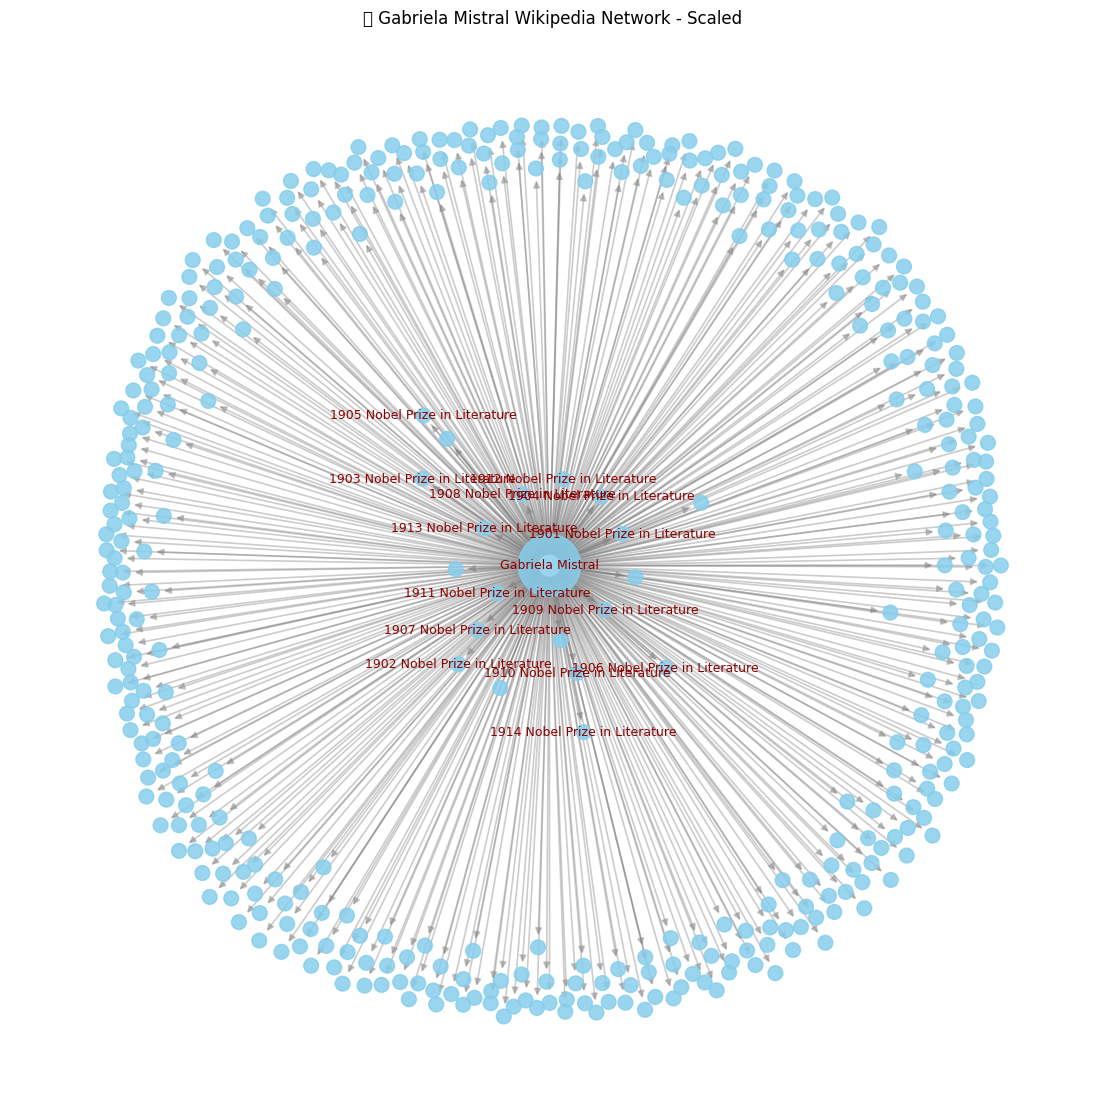

In [20]:
import matplotlib.pyplot as plt

# Compute PageRank
pagerank_scores = nx.pagerank(G)

# Set layout
plt.figure(figsize=(14, 14))
pos = nx.spring_layout(G, k=0.3, seed=42)  # Increased k for better spacing

# Node sizes scaled by PageRank
node_sizes = []
for node in G.nodes():
    if node in pagerank_scores:
        node_sizes.append(pagerank_scores[node] * 50000)
    else:
        node_sizes.append(100) # Default size for nodes without pagerank score

# Draw nodes
nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color='skyblue', alpha=0.85)

# Draw edges with arrows to show direction
nx.draw_networkx_edges(G, pos, edge_color='gray', arrows=True, arrowstyle='-|>', alpha=0.4, width=1.2)

# Draw labels
# Optionally: Only show top N labels for clarity
top_nodes = sorted(pagerank_scores.items(), key=lambda x: x[1], reverse=True)[:15]
labels = {node: node for node, _ in top_nodes}
nx.draw_networkx_labels(G, pos, labels=labels, font_size=9, font_color='darkred')

# Title and display
plt.title("📊 Gabriela Mistral Wikipedia Network - Scaled") # Added closing quote

# Title and display
plt.axis('off')
plt.show()

In [21]:
pip install plotly


In [22]:
import plotly.graph_objs as go
import networkx as nx
import numpy as np

# Compute PageRank for scaling
pagerank_scores = nx.pagerank(G)

# Create a 3D spring layout
pos = nx.spring_layout(G, dim=3, seed=42)  # 3D layout

# Extract node coordinates
xyz = np.array([pos[v] for v in G.nodes()])
Xn, Yn, Zn = xyz[:, 0], xyz[:, 1], xyz[:, 2]

# Edge coordinates
Xe, Ye, Ze = [], [], []
for e in G.edges():
    x0, y0, z0 = pos[e[0]]
    x1, y1, z1 = pos[e[1]]
    Xe += [x0, x1, None]
    Ye += [y0, y1, None]
    Ze += [z0, z1, None]

# Create trace for edges
edge_trace = go.Scatter3d(
    x=Xe, y=Ye, z=Ze,
    mode='lines',
    line=dict(color='gray', width=1),
    hoverinfo='none'
)

# Create trace for nodes with PageRank-based sizing
node_trace = go.Scatter3d(
    x=Xn, y=Yn, z=Zn,
    mode='markers+text',
    text=[f"{node}<br>PageRank: {pagerank_scores.get(node, 0):.4f}" for node in G.nodes()],
    textposition='top center',
    marker=dict(
        size=[pagerank_scores.get(node, 0) * 50 + 3 for node in G.nodes()],
        color='skyblue',
        line=dict(color='darkblue', width=0.5)
    ),
    hoverinfo='text'
)

# Create figure
fig = go.Figure(
    data=[edge_trace, node_trace],
    layout=go.Layout(
        title="🔗 3D Network: Gabriela Mistral's Wikipedia Links",
        titlefont_size=20,
        margin=dict(l=0, r=0, b=0, t=50),
        showlegend=False,
        scene=dict(
            xaxis=dict(showgrid=False, zeroline=False),
            yaxis=dict(showgrid=False, zeroline=False),
            zaxis=dict(showgrid=False, zeroline=False)
        ),
        hovermode='closest'
    )
)

# Show the 3D plot
fig.show()


In [23]:
pip install dash pandas plotly

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 12.0 MB/s eta 0:00:00


# Creating a dashboard to visualize and interact with the data about Latin American intellectuals is a powerful way to explore the representation across gender, nationality, and more.

In [24]:
import dash
from dash import html, dcc, Input, Output
import pandas as pd
import plotly.express as px

# Load your dataset
try:
    df = pd.read_csv("latin_american_intellectuals.csv")
except Exception as e:
    raise FileNotFoundError("Dataset 'latin_american_intellectuals.csv' not found or failed to load.") from e

# Basic column check
required_columns = ["Gender", "Occupation"]
for col in required_columns:
    if col not in df.columns:
        raise ValueError(f"Missing required column in dataset: '{col}'")

# Initialize Dash app
app = dash.Dash(__name__)
app.title = "Latin American Intellectuals Dashboard"

# App layout
app.layout = html.Div([
    html.H1("Latin American Intellectuals Dashboard"),

    html.Div([
        html.Label("Filter by Gender:"),
        dcc.Dropdown(
            id="gender-filter",
            options=[{"label": g.title(), "value": g} for g in df["Gender"].dropna().unique()],
            multi=True,
            placeholder="Select gender(s)..."
        ),
    ], style={'width': '30%', 'display': 'inline-block', 'margin-bottom': '20px'}),

    dcc.Graph(id='gender-distribution'),
    dcc.Graph(id='occupation-distribution'),
])

# Callbacks
@app.callback(
    [Output("gender-distribution", "figure"),
     Output("occupation-distribution", "figure")],
    [Input("gender-filter", "value")]
)
def update_graphs(selected_genders):
    filtered_df = df.copy()

    if selected_genders:
        filtered_df = filtered_df[filtered_df["Gender"].isin(selected_genders)]

    # Plot Gender Distribution
    fig_gender = px.histogram(
        filtered_df,
        x="Gender",
        title="Gender Distribution",
        color="Gender"
    )

    # Plot Occupation Distribution
    fig_occupation = px.histogram(
        filtered_df,
        x="Occupation",
        title="Occupation Distribution",
        color="Occupation"
    )

    return fig_gender, fig_occupation

# Run the app
if __name__ == '__main__':
    app.run(debug=True)

<IPython.core.display.Javascript object>

# **Extended Dash dashboard to include a search bar that allows users to select a Latin American intellectual by name and visualize their connections**

In [25]:
import dash
from dash import html, dcc, Input, Output
import pandas as pd
import plotly.express as px

# Load dataset
df = pd.read_csv("latin_american_intellectuals.csv")

# Simulated connections dictionary (OUTGOING connections only)
connections = {
    "Gabriela Mistral": ["Pablo Neruda", "Victoria Ocampo"],
    "Pablo Neruda": ["Gabriela Mistral", "Octavio Paz"],
    "Octavio Paz": ["Pablo Neruda"],
    "Victoria Ocampo": ["Gabriela Mistral"],
    # Add more as needed...
}

# Compute incoming links from the connections dict
def get_incoming_connections(name):
    incoming = []
    for source, targets in connections.items():
        if name != source and name in targets:
            incoming.append(source)
    return incoming

# Initialize Dash app
app = dash.Dash(__name__)
app.title = "Latin American Intellectuals Dashboard"

# App layout
app.layout = html.Div([
    html.H1("Latin American Intellectuals Dashboard"),

    html.Div([
        html.Label("Filter by Gender:"),
        dcc.Dropdown(
            id="gender-filter",
            options=[{"label": g.title(), "value": g} for g in df["Gender"].dropna().unique()],
            multi=True,
            placeholder="Select gender(s)..."
        ),
    ], style={'width': '30%', 'display': 'inline-block'}),

    html.Div([
        html.Label("Search by Name:"),
        dcc.Dropdown(
            id="name-search",
            options=[{"label": n, "value": n} for n in df["Name"].dropna().unique()],
            placeholder="Select a person..."
        ),
    ], style={'width': '50%', 'display': 'inline-block', 'paddingLeft': '20px'}),

    dcc.Graph(id='gender-distribution'),
    dcc.Graph(id='occupation-distribution'),

    html.Div(id='connections-output', style={'paddingTop': '20px', 'fontSize': '18px'})
])

# Callback: Update histograms based on gender filter
@app.callback(
    [Output("gender-distribution", "figure"),
     Output("occupation-distribution", "figure")],
    [Input("gender-filter", "value")]
)
def update_graphs(selected_genders):
    filtered_df = df.copy()
    if selected_genders:
        filtered_df = filtered_df[filtered_df["Gender"].isin(selected_genders)]

    fig_gender = px.histogram(filtered_df, x="Gender", title="Gender Distribution", color="Gender")
    fig_occupation = px.histogram(filtered_df, x="Occupation", title="Occupation Distribution", color="Occupation")

    return fig_gender, fig_occupation

# Callback: Show incoming & outgoing connections
@app.callback(
    Output("connections-output", "children"),
    [Input("name-search", "value")]
)
def show_connections(selected_name):
    if not selected_name:
        return ""

    outgoing = connections.get(selected_name, [])
    incoming = get_incoming_connections(selected_name)

    if not outgoing and not incoming:
        return html.Div(f"No known connections for {selected_name}.", style={"color": "gray"})

    return html.Div([
        html.H3(f"Connections for {selected_name}:"),
        html.Div([
            html.Strong("🔄 Outgoing Connections:"),
            html.Ul([html.Li(name) for name in outgoing]) if outgoing else html.P("None")
        ]),
        html.Div([
            html.Strong("🔁 Incoming Connections:"),
            html.Ul([html.Li(name) for name in incoming]) if incoming else html.P("None")
        ])
    ])

# Run the Dash server
if __name__ == '__main__':
    app.run(debug=True)

<IPython.core.display.Javascript object>

✅ Total nodes: 426
✅ Total edges: 450
🔁 Pages linking back to Gabriela Mistral: 25


/tmp/ipython-input-27-1172573367.py:88: UserWarning:

Glyph 128260 (\N{ANTICLOCKWISE DOWNWARDS AND UPWARDS OPEN CIRCLE ARROWS}) missing from font(s) DejaVu Sans.

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Glyph 128260 (\N{ANTICLOCKWISE DOWNWARDS AND UPWARDS OPEN CIRCLE ARROWS}) missing from font(s) DejaVu Sans.



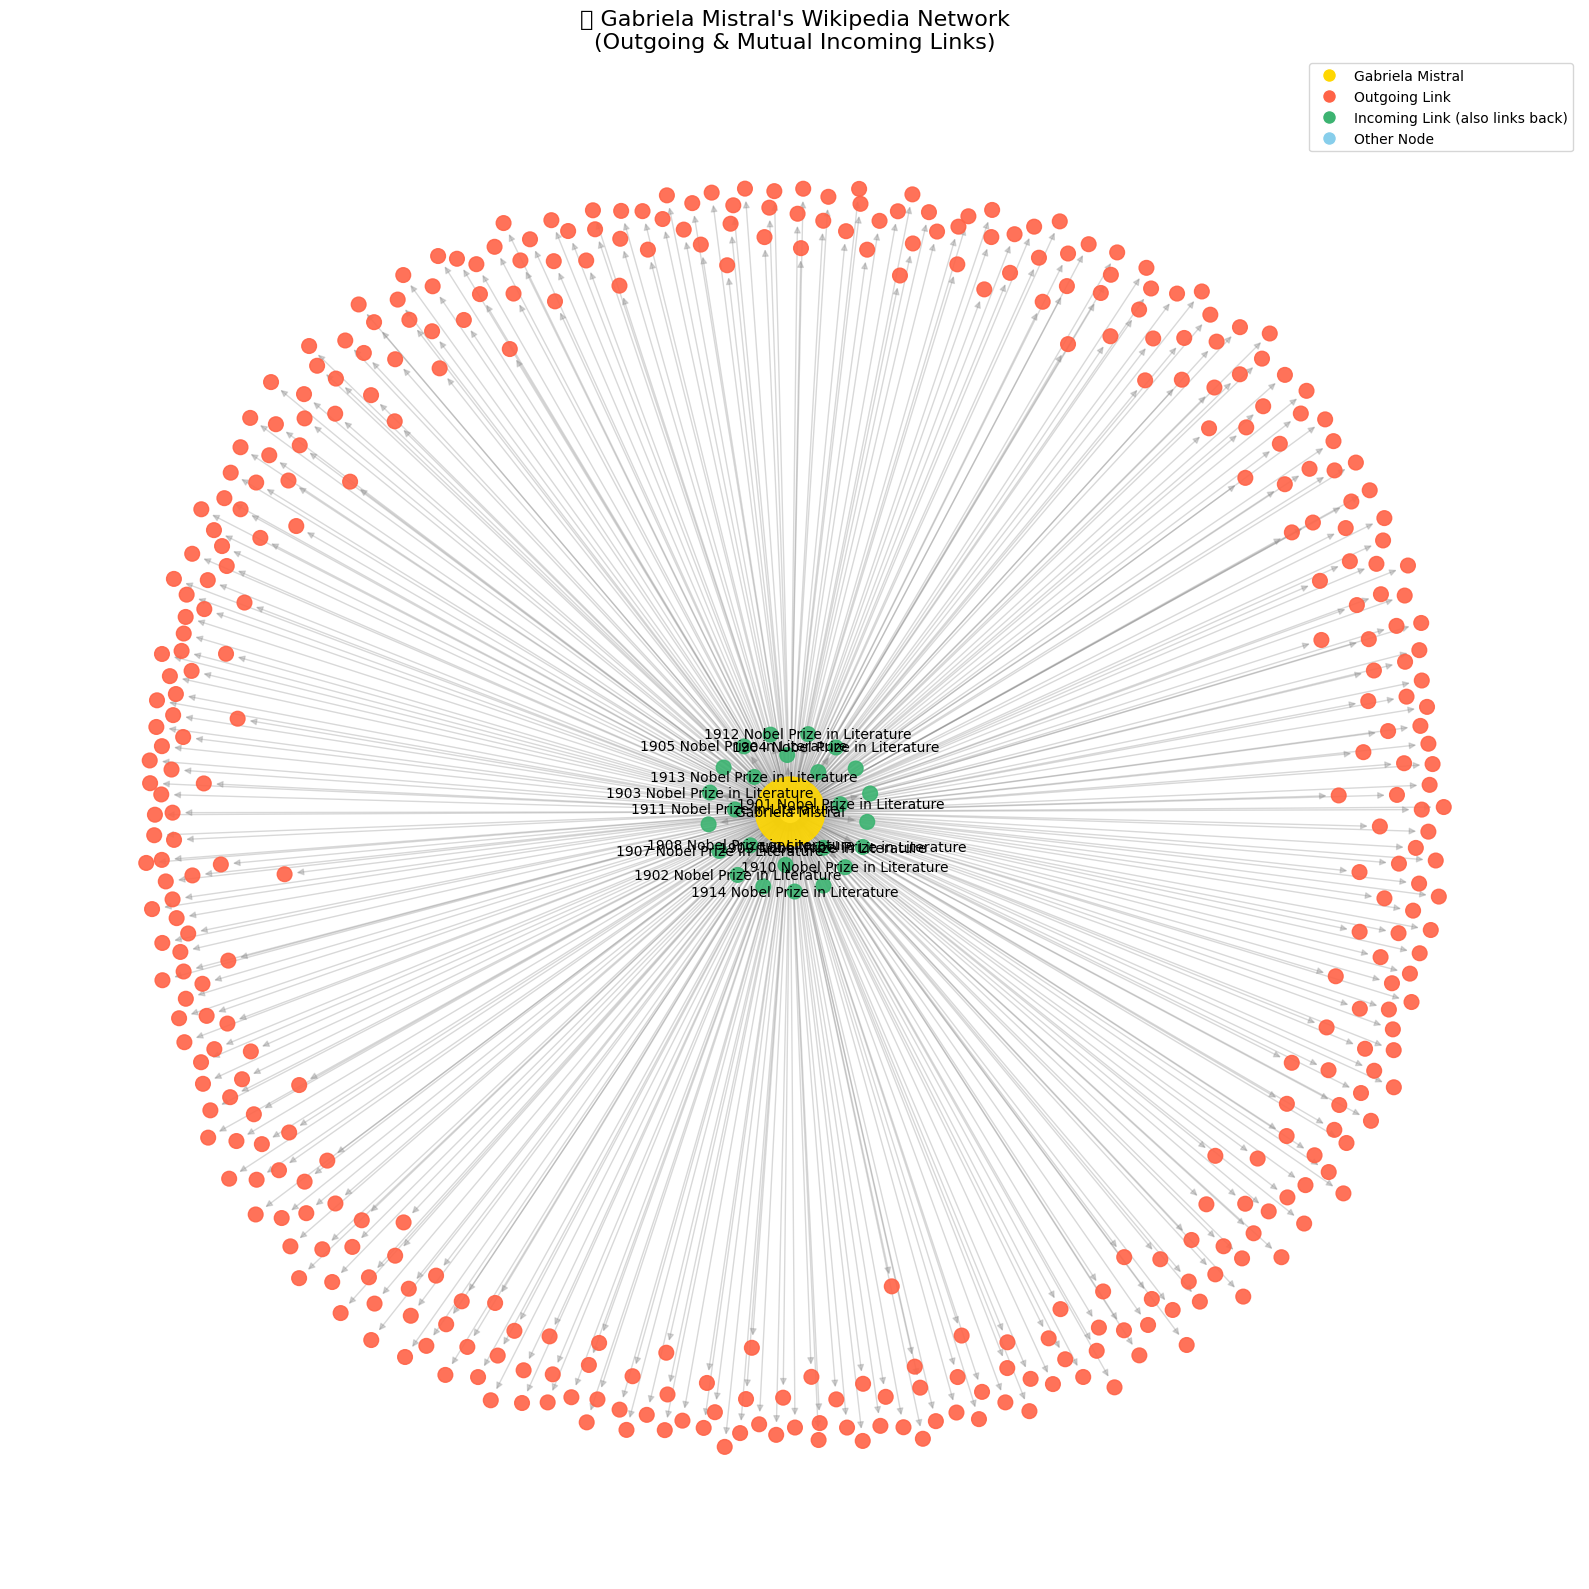

In [27]:
import wikipediaapi
import matplotlib.pyplot as plt
import networkx as nx
from matplotlib.lines import Line2D

# --- Config ---
person = "Gabriela Mistral"
wiki = wikipediaapi.Wikipedia(language="en", user_agent="GabrielaMistralNetwork/1.0 (touseeqkhanswl@gmail.com)")

# --- Create Graph ---
G = nx.DiGraph()
G.add_node(person)

# --- Fetch outgoing links from Gabriela Mistral's page ---
try:
    page = wiki.page(person)
    links = list(page.links.keys()) if page.exists() else []
except Exception as e:
    print(f"Error fetching Wikipedia page for {person}: {e}")
    links = []

# --- Add outgoing links ---
for link in links:
    G.add_node(link)
    G.add_edge(person, link)  # Edge: Gabriela → Linked Page

# --- Simulate incoming links (bidirectional check) ---
incoming_sources = []
for link in links[:25]:  # Limit for speed
    try:
        sub_page = wiki.page(link)
        if sub_page.exists() and person in sub_page.links:
            G.add_edge(link, person)  # Edge: Linked Page → Gabriela
            incoming_sources.append(link)
    except Exception:
        continue

# --- Network Info ---
print(f"✅ Total nodes: {G.number_of_nodes()}")
print(f"✅ Total edges: {G.number_of_edges()}")
print(f"🔁 Pages linking back to {person}: {len(incoming_sources)}")

# --- Compute PageRank (importance) ---
pagerank_scores = nx.pagerank(G) if G.number_of_nodes() > 0 else {}

# --- Node Coloring ---
color_map = []
for node in G.nodes():
    if node == person:
        color_map.append("gold")
    elif node in incoming_sources:
        color_map.append("mediumseagreen")  # Mutual link
    elif node in links:
        color_map.append("tomato")  # Outgoing only
    else:
        color_map.append("skyblue")

# --- Node Sizing ---
node_sizes = [pagerank_scores.get(node, 0) * 50000 for node in G.nodes()] if pagerank_scores else [100] * G.number_of_nodes()

# --- Draw the Graph ---
plt.figure(figsize=(16, 16))
pos = nx.spring_layout(G, k=0.15, seed=42)

nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=color_map, alpha=0.9)
nx.draw_networkx_edges(G, pos, edge_color='gray', alpha=0.3)

# --- Labels: Top 15 by PageRank ---
if pagerank_scores:
    top_nodes = sorted(pagerank_scores.items(), key=lambda x: x[1], reverse=True)[:15]
    labels = {node: node for node, _ in top_nodes}
else:
    labels = {person: person}
nx.draw_networkx_labels(G, pos, labels=labels, font_size=10, font_color='black')

# --- Legend ---
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label=person, markerfacecolor='gold', markersize=10),
    Line2D([0], [0], marker='o', color='w', label='Outgoing Link', markerfacecolor='tomato', markersize=10),
    Line2D([0], [0], marker='o', color='w', label='Incoming Link (also links back)', markerfacecolor='mediumseagreen', markersize=10),
    Line2D([0], [0], marker='o', color='w', label='Other Node', markerfacecolor='skyblue', markersize=10)
]
plt.legend(handles=legend_elements, loc='upper right')

# --- Final Touch ---
plt.title("🔄 Gabriela Mistral's Wikipedia Network\n(Outgoing & Mutual Incoming Links)", fontsize=16)
plt.axis('off')
plt.tight_layout()
plt.show()
